In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random 
import statsmodels.tsa.stattools as sm
from scipy import integrate
import dynamical.nonlinear as nl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

In [453]:
channel = 100
session = 1
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'

matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
ecog = matfile['ECoGData_ch'+str(channel)]
data = ecog[timefile['ConditionIndex'][0]:timefile['ConditionIndex'][1]]

###### nonlinear forecasting:
for every embedding dimension:

..for every sample in test set:

....for every # of nearest neighbors:        

......for every # of prediction time steps:
        
        -find the nearest neighbor in the training set for each point in test set at that embedding dimension
        - the embedding is only necessary for finding the nearest neighbor, at which point forecasting is done
            with the 1-dimensional future of those nearest neighbors
        -get the prediction for that many time steps away
        -compare with actual data that many time steps away in test set
        -calculate R^2 and corr
            
        

array([[ 1.        ,  0.91623177],
       [ 0.91623177,  1.        ]])

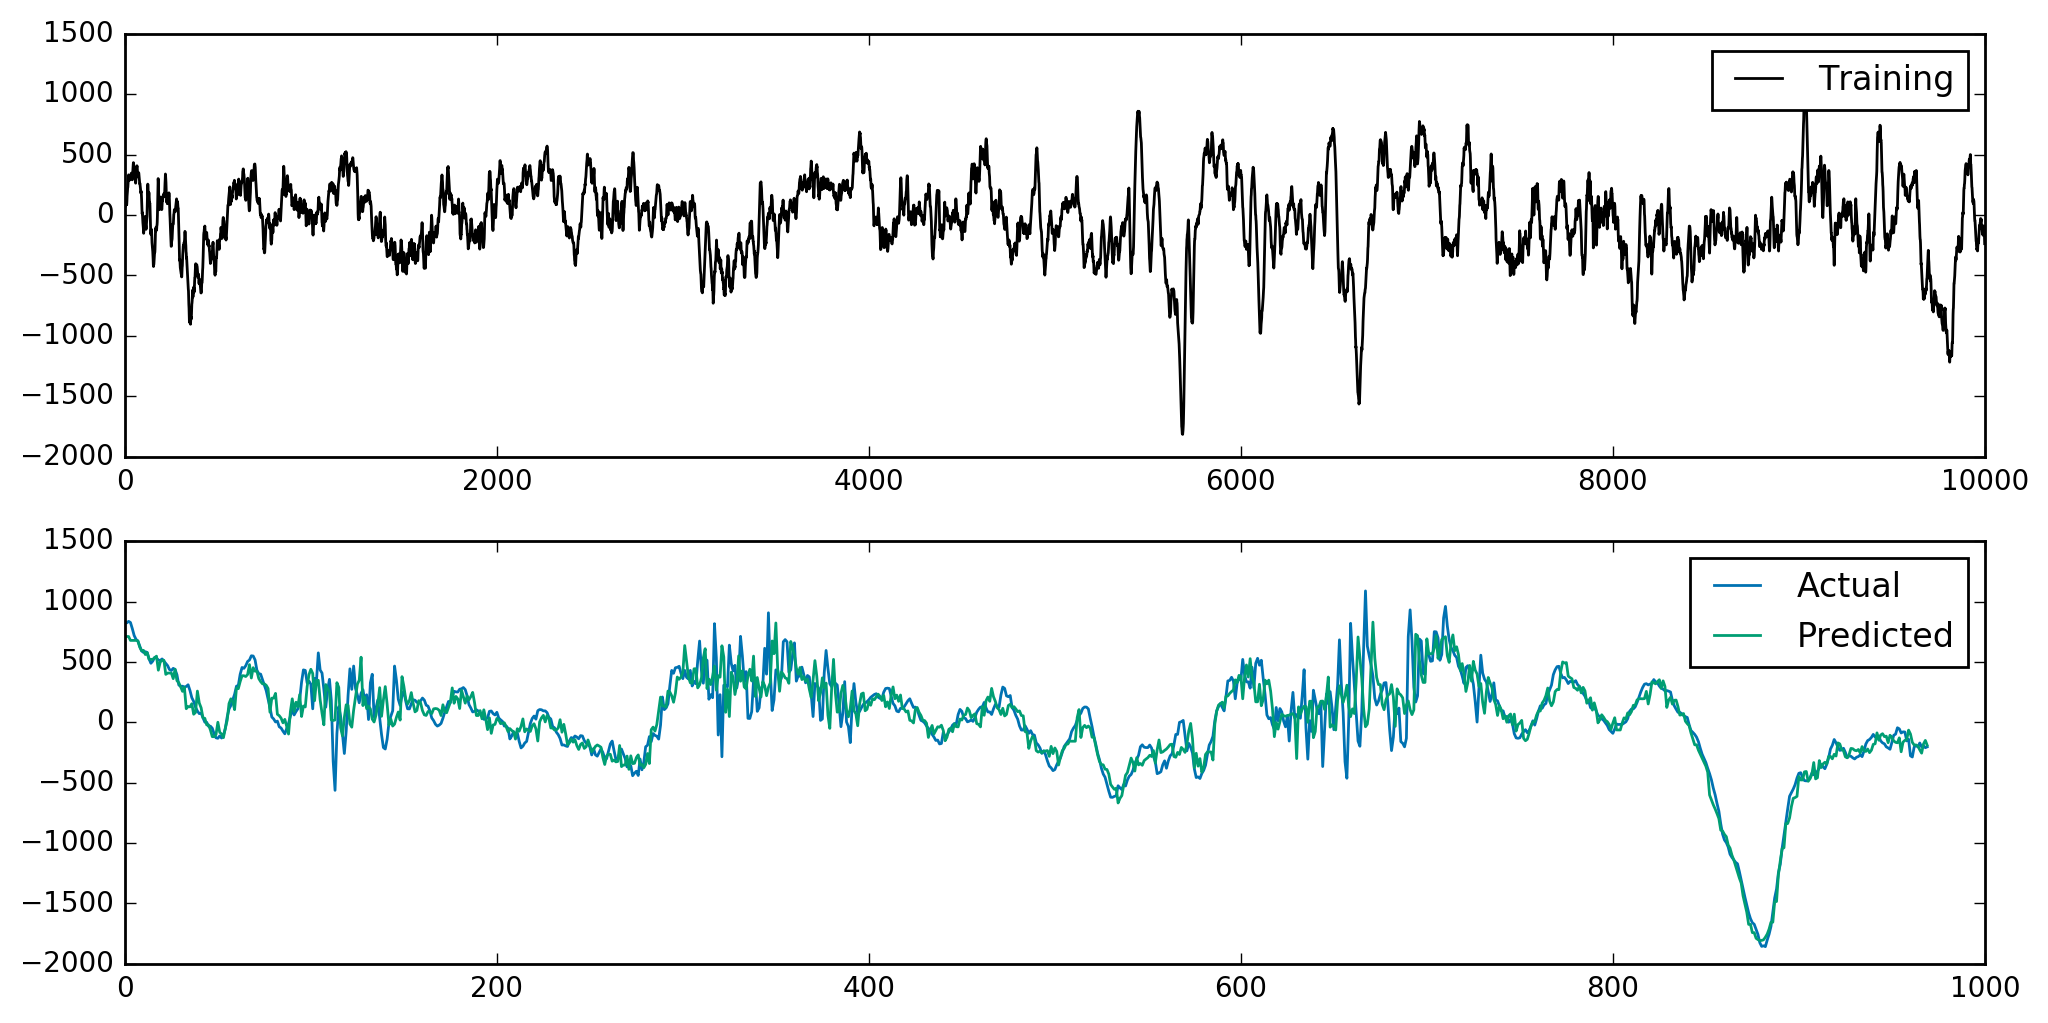

In [457]:
#reload(nl)
X_train=data[740000:750000]
X_test=data[25000:26000]

pred, val = nl.predict_at(X_train, X_test, dim=3, future=4, nn=3)
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(X_train, 'k')
plt.legend(['Training'])
plt.subplot(2,1,2)
plt.plot(val[:])
plt.plot(pred[:])
plt.legend(['Actual', 'Predicted'])
np.corrcoef(pred,val)

### main experiment
sweep through data and get prediction accuracy at different embedding dim, # of nn, and time steps into the future

### prediction on raw data

In [383]:
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'
result_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/forecasting/'

# data division
channels = np.append(np.arange(1,63), np.arange(64,129))
#15k points at 500Hz (downsampled) is 30seconds
train_len = 2000 #train on 2k data points
test_len = 500 #test on 500 data points
pad_len = 2000 #grab testing data 500 points after training data
skip_len = 5000 #skip the first 10s of data

#analysis params
max_dim = 8
max_future = 25
max_nn = 20
tau = 10

data_conds = [[0,2],[0,1,3]]
N_chks = 12

#loop through channels
for channel in channels:
    #aggregated result for channel
    rho = np.zeros((N_chks*5,max_dim,max_future,max_nn))
    rmse = np.zeros((N_chks*5,max_dim,max_future,max_nn))
    seg_cnt = 0
    print 'Chan: ', channel
    #loop through sessions
    for session in range(1,3):
        #print 'Session:', session
        timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
        matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
        ecog = matfile['ECoGData_ch'+str(channel)]
        for cond in data_conds[session-1]:
            cond_idx = timefile['ConditionIndex'][cond:cond+2]
            data = sig.decimate(ecog[cond_idx[0]:cond_idx[1]], 2, zero_phase=True)
            seg_inds = skip_len+np.arange(0,N_chks,dtype='int')*len(data)/N_chks
            for seg in seg_inds:
                train_data = data[seg:seg+train_len]
                test_data = data[seg+train_len+pad_len:seg+train_len+pad_len+test_len]
                rho[seg_cnt,:,:,:], rmse[seg_cnt,:,:,:] = nl.delay_embed_forecast(train_data, test_data, tau, max_dim, max_future, max_nn)
                seg_cnt+=1
        
    sp.io.savemat(result_path+'forecast_chan'+str(channel)+'.mat', {'rmse':rmse, 'rho':rho})                

Chan:  1
Chan:  2
Chan:  3
Chan:  4
Chan:  5
Chan:  6
Chan:  7
Chan:  8
Chan:  9
Chan:  10
Chan:  11
Chan:  12
Chan:  13
Chan:  14
Chan:  15
Chan:  16
Chan:  17
Chan:  18
Chan:  19
Chan:  20
Chan:  21
Chan:  22
Chan:  23
Chan:  24
Chan:  25
Chan:  26
Chan:  27
Chan:  28
Chan:  29
Chan:  30
Chan:  31
Chan:  32
Chan:  33
Chan:  34
Chan:  35
Chan:  36
Chan:  37
Chan:  38
Chan:  39
Chan:  40
Chan:  41
Chan:  42
Chan:  43
Chan:  44
Chan:  45
Chan:  46
Chan:  47
Chan:  48
Chan:  49
Chan:  50
Chan:  51
Chan:  52
Chan:  53
Chan:  54
Chan:  55
Chan:  56
Chan:  57
Chan:  58
Chan:  59
Chan:  60
Chan:  61
Chan:  62
Chan:  64
Chan:  65
Chan:  66
Chan:  67
Chan:  68
Chan:  69
Chan:  70
Chan:  71
Chan:  72
Chan:  73
Chan:  74
Chan:  75
Chan:  76
Chan:  77
Chan:  78
Chan:  79
Chan:  80
Chan:  81
Chan:  82
Chan:  83
Chan:  84
Chan:  85
Chan:  86
Chan:  87
Chan:  88
Chan:  89
Chan:  90
Chan:  91
Chan:  92
Chan:  93
Chan:  94
Chan:  95
Chan:  96
Chan:  97
Chan:  98
Chan:  99
Chan:  100
Chan:  101
Chan:  

###  prediction on first differenced data

In [384]:
data_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/'
result_path = '/Users/rgao/Documents/Data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/forecasting_diff/'

# data division
channels = np.append(np.arange(1,63), np.arange(64,129))
#15k points at 500Hz (downsampled) is 30seconds
train_len = 2000 #train on 2k data points
test_len = 500 #test on 500 data points
pad_len = 2000 #grab testing data 500 points after training data
skip_len = 5000 #skip the first 10s of data

#analysis params
max_dim = 8
max_future = 25
max_nn = 20
tau = 10

data_conds = [[0,2],[0,1,3]]
N_chks = 12

#loop through channels
for channel in channels:
    #aggregated result for channel
    rho = np.zeros((N_chks*5,max_dim,max_future,max_nn))
    rmse = np.zeros((N_chks*5,max_dim,max_future,max_nn))
    seg_cnt = 0
    print 'Chan: ', channel
    #loop through sessions
    for session in range(1,3):
        #print 'Session:', session
        timefile = io.loadmat(data_path + 'Session' +str(session) + '/Condition.mat', squeeze_me=True)
        matfile = io.loadmat(data_path +'Session' +str(session) + '/ECoG_ch' + str(channel) +'.mat', squeeze_me=True)
        ecog = matfile['ECoGData_ch'+str(channel)]
        for cond in data_conds[session-1]:
            cond_idx = timefile['ConditionIndex'][cond:cond+2]
            # first difference
            data = np.diff(sig.decimate(ecog[cond_idx[0]:cond_idx[1]], 2, zero_phase=True))
            seg_inds = skip_len+np.arange(0,N_chks,dtype='int')*len(data)/N_chks
            for seg in seg_inds:
                train_data = data[seg:seg+train_len]
                test_data = data[seg+train_len+pad_len:seg+train_len+pad_len+test_len]
                rho[seg_cnt,:,:,:], rmse[seg_cnt,:,:,:] = nl.delay_embed_forecast(train_data, test_data, tau, max_dim, max_future, max_nn)
                seg_cnt+=1
        
    sp.io.savemat(result_path+'forecast_chan'+str(channel)+'.mat', {'rmse':rmse, 'rho':rho})                

Chan:  1
Chan:  2
Chan:  3
Chan:  4
Chan:  5
Chan:  6
Chan:  7
Chan:  8
Chan:  9
Chan:  10
Chan:  11
Chan:  12
Chan:  13
Chan:  14
Chan:  15
Chan:  16
Chan:  17
Chan:  18
Chan:  19
Chan:  20
Chan:  21
Chan:  22
Chan:  23
Chan:  24
Chan:  25
Chan:  26
Chan:  27
Chan:  28
Chan:  29
Chan:  30
Chan:  31
Chan:  32
Chan:  33
Chan:  34
Chan:  35
Chan:  36
Chan:  37
Chan:  38
Chan:  39
Chan:  40
Chan:  41
Chan:  42
Chan:  43
Chan:  44
Chan:  45
Chan:  46
Chan:  47
Chan:  48
Chan:  49
Chan:  50
Chan:  51
Chan:  52
Chan:  53
Chan:  54
Chan:  55
Chan:  56
Chan:  57
Chan:  58
Chan:  59
Chan:  60
Chan:  61
Chan:  62
Chan:  64
Chan:  65
Chan:  66
Chan:  67
Chan:  68
Chan:  69
Chan:  70
Chan:  71
Chan:  72
Chan:  73
Chan:  74
Chan:  75
Chan:  76
Chan:  77
Chan:  78
Chan:  79
Chan:  80
Chan:  81
Chan:  82
Chan:  83
Chan:  84
Chan:  85
Chan:  86
Chan:  87
Chan:  88
Chan:  89
Chan:  90
Chan:  91
Chan:  92
Chan:  93
Chan:  94
Chan:  95
Chan:  96
Chan:  97
Chan:  98
Chan:  99
Chan:  100
Chan:  101
Chan:  